<a href="https://colab.research.google.com/github/Sarinda251/CAP_5610/blob/master/HW2_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports

In [301]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from numpy.random import seed
from numpy.random import randn
seed(1)

#Problem 1: Preprocess Data

In [288]:
train_df = pd.read_csv('train.csv')
print(train_df.columns)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [289]:
sexToGender = {
  "male": 0,
  "female": 1
}

def embClean(x):
  if str(x) == 'nan':
    return 'S'
  return x

def fareClean(x, m):
  if str(x) == 'nan':
    return m
  return x

def fareBand(x):
  if x <= 7.91:
    return 0
  if x <= 14.454:
    return 1
  if x <= 31:
    return 2
  if x <= 512.329:
    return 3
  return 4

embBand = {
    "S": 0,
    "C": 1,
    "Q": 2
}

def ageClean(x, s, a):
  if str(x) == 'nan':
    return max(float(s*randn(1) + a),0)
  return float(x)

cleanedFare  = [x for x in train_df['Fare'].values if str(x) != 'nan']
mode = statistics.mode(cleanedFare)
cleanedAge = [x for x in train_df['Age'].values if str(x) != 'nan']
avg = statistics.mean(cleanedAge)
std = statistics.stdev(cleanedAge)

train_df['Age'] = train_df['Age'].transform(lambda x: ageClean(x, std, avg))
train_df['Fare'] = train_df['Fare'].transform(lambda x: fareClean(x, mode))
train_df['Fare'] = train_df['Fare'].transform(lambda x: fareBand(x))
train_df['Embarked'] = train_df['Embarked'].transform(lambda x: embClean(x))
train_df['Embarked'] = train_df['Embarked'].transform(lambda x: embBand[x])
train_df['Gender'] = train_df['Sex'].transform(lambda x: sexToGender[x])
train_df = train_df.drop(columns=["Ticket", "Cabin", "Name", "Sex"])

In [290]:
train_df._get_numeric_data()

PassengerId  Survived  Pclass        Age  ...  Parch  Fare  Embarked  Gender
0              1         0       3  22.000000  ...      0     0         0       0
1              2         1       1  38.000000  ...      0     3         1       1
2              3         1       3  26.000000  ...      0     1         0       1
3              4         1       1  35.000000  ...      0     3         0       1
4              5         0       3  35.000000  ...      0     1         0       0
..           ...       ...     ...        ...  ...    ...   ...       ...     ...
886          887         0       2  27.000000  ...      0     1         0       0
887          888         1       1  19.000000  ...      0     2         0       1
888          889         0       3  49.040526  ...      2     2         0       1
889          890         1       1  26.000000  ...      0     2         1       0
890          891         0       3  32.000000  ...      0     0         2       0

[891 rows x 9 columns]

In [291]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    int64  
 7   Embarked     891 non-null    int64  
 8   Gender       891 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 62.8 KB


all null values have been filled, and columns have been turned into numerical datatypes.

In [292]:
train_x = train_df.drop(columns=["PassengerId", "Survived"])
train_y = train_df["Survived"]

In [293]:
train_x.describe()

Pclass         Age       SibSp  ...        Fare    Embarked      Gender
count  891.000000  891.000000  891.000000  ...  891.000000  891.000000  891.000000
mean     2.308642   29.933108    0.523008  ...    1.508418    0.361392    0.352413
std      0.836071   14.286985    1.102743  ...    1.124141    0.635673    0.477990
min      1.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%      2.000000   20.869353    0.000000  ...    0.500000    0.000000    0.000000
50%      3.000000   29.000000    0.000000  ...    2.000000    0.000000    0.000000
75%      3.000000   38.841008    1.000000  ...    2.000000    1.000000    1.000000
max      3.000000   80.000000    8.000000  ...    4.000000    2.000000    1.000000

[8 rows x 7 columns]

In [294]:
train_y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

#Problem 2: Feature Selection

In [295]:
print(train_df)

     PassengerId  Survived  Pclass        Age  ...  Parch  Fare  Embarked  Gender
0              1         0       3  22.000000  ...      0     0         0       0
1              2         1       1  38.000000  ...      0     3         1       1
2              3         1       3  26.000000  ...      0     1         0       1
3              4         1       1  35.000000  ...      0     3         0       1
4              5         0       3  35.000000  ...      0     1         0       0
..           ...       ...     ...        ...  ...    ...   ...       ...     ...
886          887         0       2  27.000000  ...      0     1         0       0
887          888         1       1  19.000000  ...      0     2         0       1
888          889         0       3  49.040526  ...      2     2         0       1
889          890         1       1  26.000000  ...      0     2         1       0
890          891         0       3  32.000000  ...      0     0         2       0

[891 rows x 9 c

[0.11629469 0.33940418 0.06952836 0.03777199 0.08160142 0.03320817
 0.32219118]


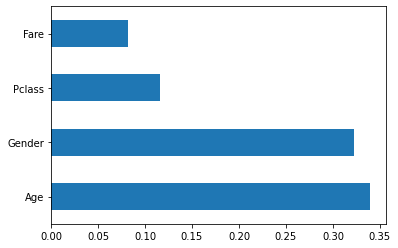

In [296]:
model = DecisionTreeClassifier()
model.fit(train_x,train_y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=train_x.columns)
feat_importances.nlargest(4).plot(kind='barh')
plt.show()

I used the decisiontreeclassifier from scikit to select the top 4 variables based on the feature importance of the model.

#Problem 3: Decision Tree with Gini Index

In [297]:
train_x = train_x[["Fare", "Pclass", "Gender", "Age"]]
train_x.describe()

Fare      Pclass      Gender         Age
count  891.000000  891.000000  891.000000  891.000000
mean     1.508418    2.308642    0.352413   29.933108
std      1.124141    0.836071    0.477990   14.286985
min      0.000000    1.000000    0.000000    0.000000
25%      0.500000    2.000000    0.000000   20.869353
50%      2.000000    3.000000    0.000000   29.000000
75%      2.000000    3.000000    1.000000   38.841008
max      4.000000    3.000000    1.000000   80.000000

The decision tree classifier uses gini index as a default 

In [298]:
clf = DecisionTreeClassifier()  
clf = clf.fit(train_x,train_y)

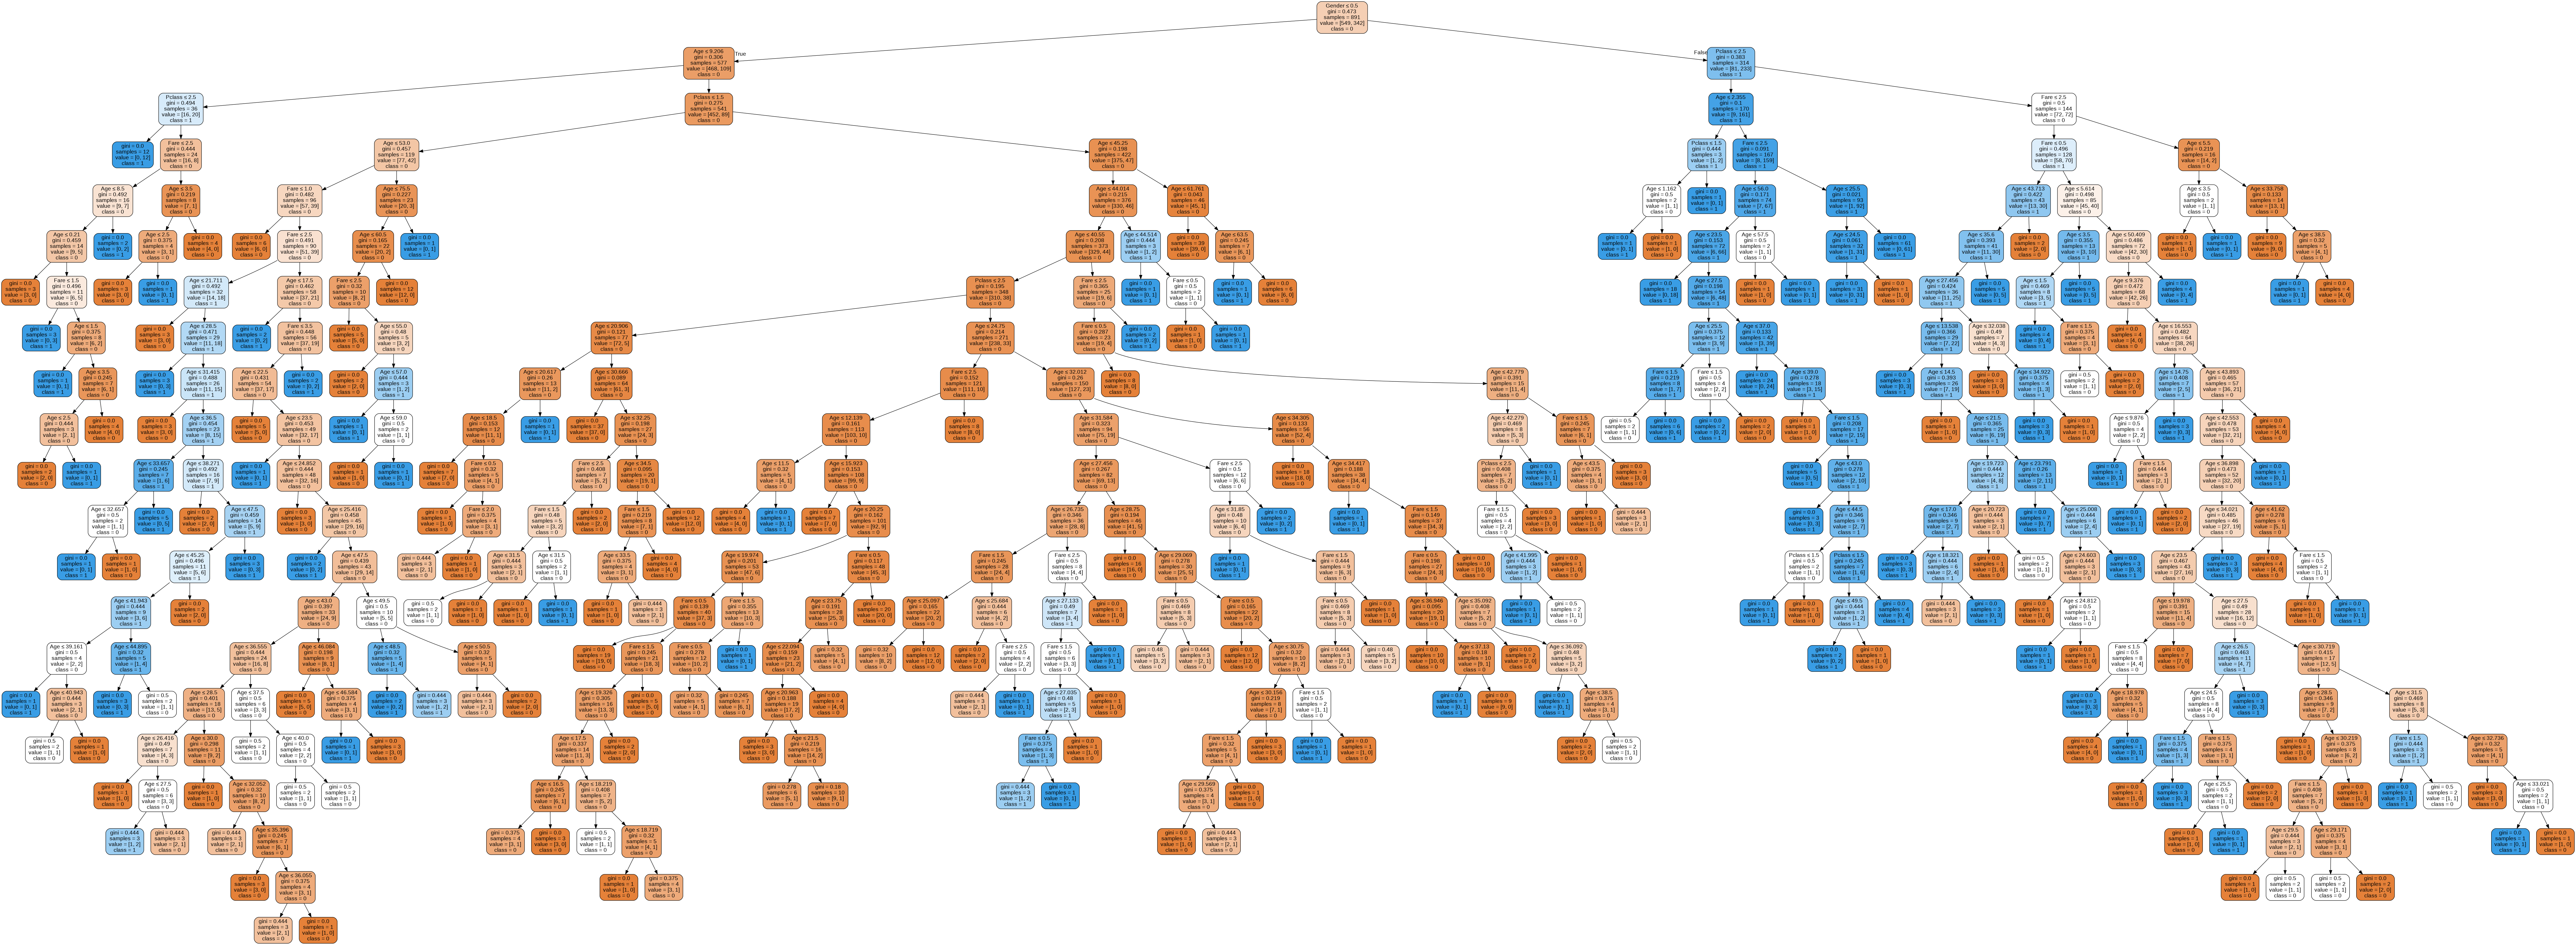

In [299]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = train_x.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('titanic.png')
Image(graph.create_png())

#Problem 4

In [300]:
acc = cross_val_score(clf, train_x, train_y, cv=5)
print(statistics.mean(acc))

0.768853179335886


#Problem 5

In [303]:
clf2 = RandomForestClassifier()  
clf2 = clf.fit(train_x,train_y)
acc2 = cross_val_score(clf2, train_x, train_y, cv=5)
print(statistics.mean(acc2))

0.7733350072186304
